# MML 2 - Merging Data and Computing Anomalies

In this notebook, we combine two datasets. For this, we need to bring them to the same grid, so we do that as well. Finally, we compute monthly anomalies.

We once more start by taking the snippet from xcube viewer to open the SST dataset:

In [1]:
from xcube.core.store import new_data_store

store = new_data_store(
    "s3",
    root="datasets",  # can also use "pyramids" here
    storage_options={
        "anon": True,
        "client_kwargs": {
            "endpoint_url": "https://doors.api.brockmann-consult.de/api/s3"
        }
    }
)
# store.list_data_ids()
sst_dataset = store.open_data(data_id="cmems-sst-bs.zarr")
sst_dataset

<xarray.Dataset>
Dimensions:       (time: 3085, latitude: 200, longitude: 321)
Coordinates:
  * latitude      (latitude) float32 38.72 38.78 38.83 ... 48.67 48.72 48.78
  * longitude     (longitude) float32 26.38 26.42 26.48 ... 42.28 42.33 42.38
  * time          (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2024-06-11
Data variables:
    analysed_sst  (time, latitude, longitude) float32 dask.array<chunksize=(1, 200, 321), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                CF-1.4
    DSD_entry_id:               -GOS-L4HRfnd-BLK
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Scaling_Equation:           (scale_factor*data) + add_offset
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    ...                         ...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    time_coverage_end:          20240508T190000Z
    time_coverage_start:        20160101T070000Z
    title:                      CMEMS SST Black Sea
    uuid:                        
    westernmost_longitude:      26.375

Now, let's open another dataset. We use `sst_monthly.zarr`, which you can find in the `data` folder. We simply open it with xarray, which we import first.

In [2]:
import xarray as xr

In [3]:
other_sst_data = xr.open_zarr("data/sst_monthly.zarr")
other_sst_data

<xarray.Dataset>
Dimensions:    (latitude: 215, longitude: 395, time: 102)
Coordinates:
  * latitude   (latitude) float64 40.86 40.89 40.92 40.94 ... 46.75 46.78 46.8
  * longitude  (longitude) float64 27.37 27.41 27.44 27.48 ... 41.89 41.93 41.96
  * time       (time) datetime64[ns] 2015-12-31 2016-01-31 ... 2024-05-31
Data variables:
    other_sst  (time, latitude, longitude) float64 dask.array<chunksize=(1, 215, 395), meta=np.ndarray>

On inspection, you can see the dimensions are different. The datasets come in different spatial and temporal grids. The DOORS CMEMS dataset we importe first is in a daily resolution, while the other one in a monthly. If we want to combine them, it is good to bring them to the same grids. Let's take care of the time first by resampling the DOORS CMEMS dataset to a monthly resolution. We use the `resample_in_time` function from xcube for this. `frequency` denotes the desired temporal period, `method` the way the values are aggregated.

In [4]:
from xcube.core.resampling import resample_in_time

In [5]:
cmems_sst_monthly_dataset = resample_in_time(sst_dataset, frequency='M', method='mean')
cmems_sst_monthly_dataset

<xarray.Dataset>
Dimensions:            (time: 102, latitude: 200, longitude: 321)
Coordinates:
  * latitude           (latitude) float32 38.72 38.78 38.83 ... 48.72 48.78
  * longitude          (longitude) float32 26.38 26.42 26.48 ... 42.33 42.38
  * time               (time) datetime64[ns] 2015-12-31 ... 2024-05-31
Data variables:
    analysed_sst_mean  (time, latitude, longitude) float32 dask.array<chunksize=(1, 200, 321), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                CF-1.4
    DSD_entry_id:               -GOS-L4HRfnd-BLK
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Scaling_Equation:           (scale_factor*data) + add_offset
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    ...                         ...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    time_coverage_end:          <xarray.DataArray 'time' ()>\narray('2024-06-...
    time_coverage_start:        <xarray.DataArray 'time' ()>\narray('2016-01-...
    title:                      CMEMS SST Black Sea
    uuid:                        
    westernmost_longitude:      26.375

As the datasets were covering the same temporal period, they now have the same time dimension of 102. We can now resample the grid. For this, we can use the `resample_in_space` function. To use this, however, we need to specify the grid mappings of the two datasets. The grid mapping defines the spatial grid of a dataset and describes its properties such as the resolution, the crs, and sizes.

In [6]:
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_space

In [7]:
other_sst_gm = GridMapping.from_dataset(other_sst_data)
cmems_sst_monthly_gm = GridMapping.from_dataset(cmems_sst_monthly_dataset)

Now that we have the grid mappings, we can actually resample. We bring the other sst data onto the grid of the cmems sst data (we could also do it the other way round). This step might take a bit.

In [8]:
other_resampled_sst_data = resample_in_space(other_sst_data, source_gm=other_sst_gm, target_gm=cmems_sst_monthly_gm)
other_resampled_sst_data

<xarray.Dataset>
Dimensions:         (time: 102, latitude: 200, longitude: 321, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 2015-12-31 2016-01-31 ... 2024-05-31
  * longitude       (longitude) float64 26.38 26.43 26.48 ... 42.27 42.33 42.38
  * latitude        (latitude) float64 38.72 38.78 38.83 ... 48.67 48.72 48.78
    longitude_bnds  (longitude, bnds) float64 26.35 26.4 26.4 ... 42.35 42.4
    latitude_bnds   (latitude, bnds) float64 38.7 38.75 38.75 ... 48.75 48.8
Dimensions without coordinates: bnds
Data variables:
    other_sst       (time, latitude, longitude) float64 dask.array<chunksize=(1, 200, 321), meta=np.ndarray>
    crs             int64 0

The dimension sizes are looking good now! However, when you compare the actual latitude and longitude values between the resampled and the reference dataset, you will notice that they are slightly off due to different roundings. We overcome this issue by assigning the coordinate arrays from the reference dataset to the resampled one.

In [9]:
other_resampled_sst_data['latitude'] = cmems_sst_monthly_dataset['latitude']
other_resampled_sst_data['longitude'] = cmems_sst_monthly_dataset['longitude']

Now the datasets have the same spatial and temporal grids, and we can merge them into one. Technically, this would have also been possible without the resampling steps, but that would have resulted in a very bloated dataset with irregular dimensions.

In [10]:
combined_sst_data = xr.merge([cmems_sst_monthly_dataset, other_resampled_sst_data])
combined_sst_data

<xarray.Dataset>
Dimensions:            (time: 102, latitude: 200, longitude: 321, bnds: 2)
Coordinates:
  * latitude           (latitude) float32 38.72 38.78 38.83 ... 48.72 48.78
  * longitude          (longitude) float32 26.38 26.42 26.48 ... 42.33 42.38
  * time               (time) datetime64[ns] 2015-12-31 ... 2024-05-31
    longitude_bnds     (longitude, bnds) float64 26.35 26.4 26.4 ... 42.35 42.4
    latitude_bnds      (latitude, bnds) float64 38.7 38.75 38.75 ... 48.75 48.8
Dimensions without coordinates: bnds
Data variables:
    analysed_sst_mean  (time, latitude, longitude) float32 dask.array<chunksize=(1, 200, 321), meta=np.ndarray>
    other_sst          (time, latitude, longitude) float64 dask.array<chunksize=(1, 200, 321), meta=np.ndarray>
    crs                int64 0
Attributes: (12/52)
    Conventions:                CF-1.4
    DSD_entry_id:               -GOS-L4HRfnd-BLK
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Scaling_Equation:           (scale_factor*data) + add_offset
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    ...                         ...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    time_coverage_end:          <xarray.DataArray 'time' ()>\narray('2024-06-...
    time_coverage_start:        <xarray.DataArray 'time' ()>\narray('2016-01-...
    title:                      CMEMS SST Black Sea
    uuid:                        
    westernmost_longitude:      26.375

... and there we have it, a single dataset. Of course, now we would really like to compare the values from the different variables. One easy way to do this is to simply build the diff:

In [11]:
sst_diff = combined_sst_data.analysed_sst_mean - combined_sst_data.other_sst
combined_sst_data = combined_sst_data.assign({"sst_diff": sst_diff})
combined_sst_data

<xarray.Dataset>
Dimensions:            (time: 102, latitude: 200, longitude: 321, bnds: 2)
Coordinates:
  * latitude           (latitude) float32 38.72 38.78 38.83 ... 48.72 48.78
  * longitude          (longitude) float32 26.38 26.42 26.48 ... 42.33 42.38
  * time               (time) datetime64[ns] 2015-12-31 ... 2024-05-31
    longitude_bnds     (longitude, bnds) float64 26.35 26.4 26.4 ... 42.35 42.4
    latitude_bnds      (latitude, bnds) float64 38.7 38.75 38.75 ... 48.75 48.8
Dimensions without coordinates: bnds
Data variables:
    analysed_sst_mean  (time, latitude, longitude) float32 dask.array<chunksize=(1, 200, 321), meta=np.ndarray>
    other_sst          (time, latitude, longitude) float64 dask.array<chunksize=(1, 200, 321), meta=np.ndarray>
    crs                int64 0
    sst_diff           (time, latitude, longitude) float64 dask.array<chunksize=(1, 200, 321), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                CF-1.4
    DSD_entry_id:               -GOS-L4HRfnd-BLK
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Scaling_Equation:           (scale_factor*data) + add_offset
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    ...                         ...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    time_coverage_end:          <xarray.DataArray 'time' ()>\narray('2024-06-...
    time_coverage_start:        <xarray.DataArray 'time' ()>\narray('2016-01-...
    title:                      CMEMS SST Black Sea
    uuid:                        
    westernmost_longitude:      26.375

And we can have a look at the resulting diffs.

/opt/conda/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/array/chunk.py:138: RuntimeWarning: Mean of empty slice
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)), **kwargs)


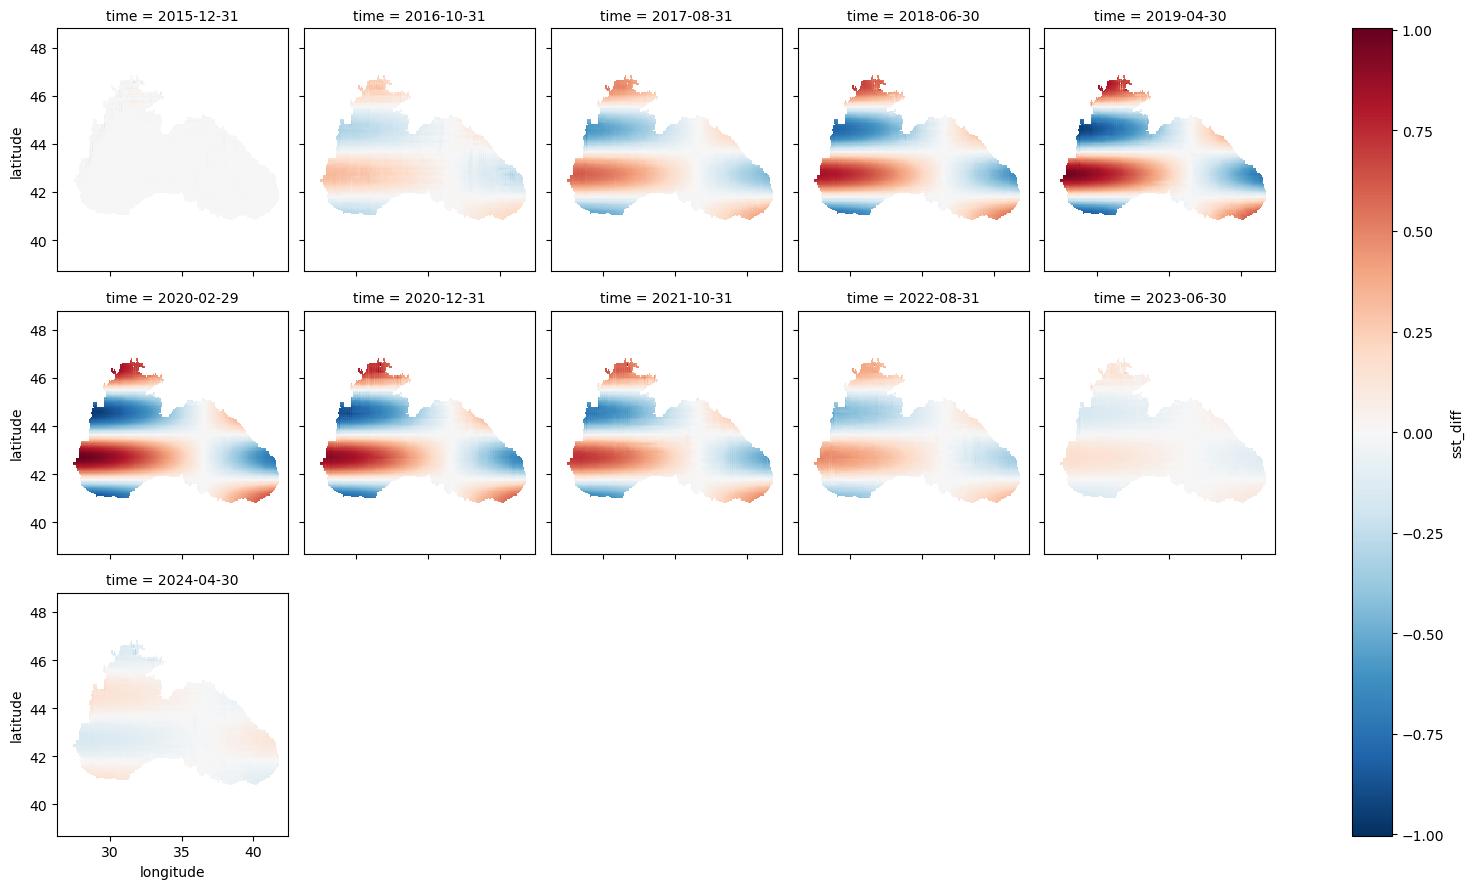

In [12]:
combined_sst_data["sst_diff"].isel(time=slice(0, 102, 10)).plot.imshow(col="time", col_wrap=5)

Now, what about finding anomalies in the temperature data? For this, we need to compute the mean and then we can compute the diff for each month. This can be achieved like this:

In [13]:
months = ["december", "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november"]

monthly_sst = {}
monthly_sst_means = {}
monthly_sst_anomalies = {}
for i, month in enumerate(months):
    monthly_sst[month] = combined_sst_data.analysed_sst_mean[i::12]
    monthly_sst_means[month] = monthly_sst[month].mean(dim="time")
    monthly_sst_anomalies[month] = monthly_sst[month] - monthly_sst_means[month]

Note that the outcome is not a dataset but a dictionary. We may now look at a monthly mean like this:

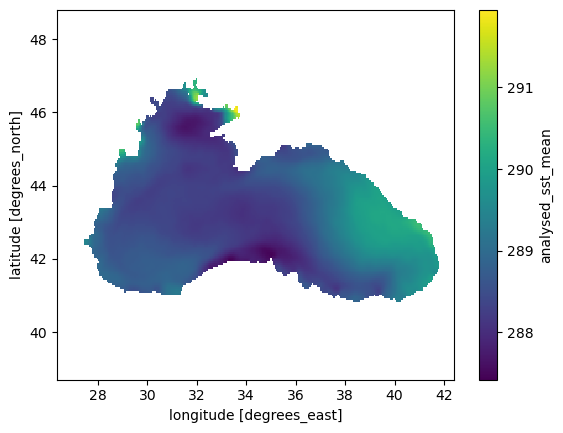

In [14]:
monthly_sst_means["april"].plot()

To see the anomalies for each month, we can come up with an auxiliary function that plots the annual anomalies for each month:

In [15]:
def show_monthly_anomalies(month: str):
    monthly_sst_anomalies[month].plot.imshow(col="time", col_wrap=3)

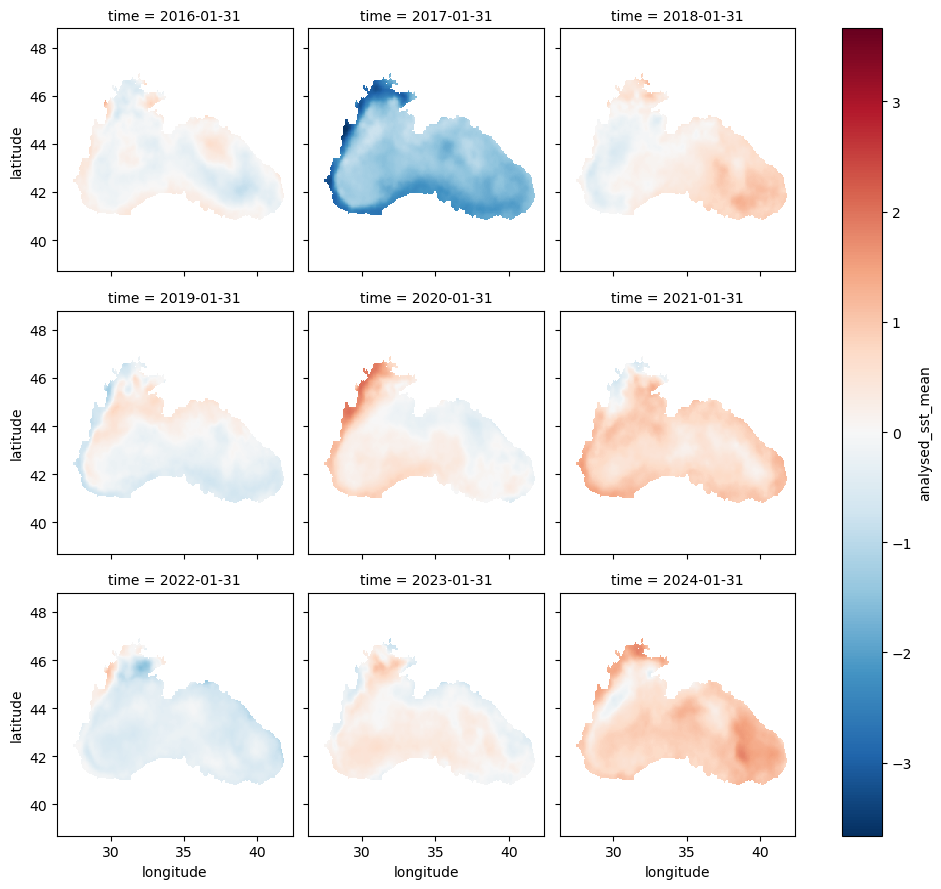

In [16]:
show_monthly_anomalies("january")